# Projekt ko≈Ñcowy PwC
Sk≈Çad grupy projektowej: Magdalena Lamczyk, Wiktoria Sarabon\
Mentorzy: Anna Pielowska, Micha≈Ç Sucharski

## Zadanie

**Krok 1**: Pobierz historyczne ceny akcji/surowc√≥w/walut dla dw√≥ch aktyw√≥w, kt√≥re uwa≈ºasz za powiƒÖzane (inne ni≈º do tej pory). Skomentuj wyb√≥r. Przekszta≈Çƒá pobrane dane w szeregi czasowe strat o wybranej czƒôstotliwo≈õci i zakresie.\
**Krok 2**: Oblicz podstawowe statystyki, dopasuj rozk≈Çady brzegowe, narysuj wykres obu szereg√≥w, policz ich korelacjƒô Spearmana/tau Kendalla/dowolne wybrane miary zale≈ºno≈õci i skomentuj wszystkie analizy.\
**Krok 3**: Dopasuj r√≥≈ºne kopu≈Çy (T-Studenta, normalnƒÖ, Claytona, Franka, Gumbela) do po≈ÇƒÖczonych szereg√≥w czasowych strat i u≈ºyj kryteri√≥w log-likelihood, AIC i BIC, aby wybraƒá najlepiej dopasowanƒÖ kopu≈Çƒô. Wykonaj test Mardia dla zbadania wielowymiarowej normalno≈õci. Skomentuj wyniki. Narysuj wykres dopasowania najlepszej kopu≈Çy do danych historycznych.\
**Krok 4a**: Wygeneruj $N$ wektor√≥w ($x_1,x_2$) za pomocƒÖ dopasowanych rozk≈Çad√≥w brzegowych (traktujƒÖc oba rozk≈Çady aktyw√≥w niezale≈ºnie, brak wykorzystania kopu≈Çy). Dopasuj taki parametr $\beta \in [0,1]$, ≈ºe VaR dla portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy. Zinterpretuj warto≈õƒá $\beta$.\
**Krok 4b**: Wygeneruj $N$ wektor√≥w ($x_1,x_2$) za pomocƒÖ dopasowanej kopu≈Çy z rozk≈Çad√≥w brzegowych (wektory bƒôdƒÖ w√≥wczas zawieraƒá zale≈ºno≈õƒá narzuconƒÖ przez dopasowanƒÖ kopu≈Çƒô). Dopasuj taki parametr $\beta \in [0,1]$, ≈ºe VaR dla portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy. Zinterpretuj warto≈õƒá $\beta$. Por√≥wnaj wyniki z krokiem 4a i skomentuj r√≥≈ºnice.\
**Krok 5**: Por√≥wnaj wyniki z 4a i 4b. Sprawd≈∫, jak zmieniajƒÖ siƒô wyniki dla dw√≥ch r√≥≈ºnych poziom√≥w VaR i warto≈õci $N$. Skomentuj.

## Importy

In [1]:
# pip install numpy pandas seaborn matplotlib yfinance pymannkendall statsmodels scipy sklarpy copulas pingouin
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import yfinance as yf
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, kstest, shapiro, t, pearsonr, kendalltau, spearmanr
from sklarpy.copulas import student_t_copula, gaussian_copula, clayton_copula, gumbel_copula, frank_copula
import warnings
warnings.filterwarnings("ignore")
from sklarpy.univariate import student_t
from copulas.univariate import (
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate,
    LogLaplace,
    TruncatedGaussian,
    UniformUnivariate
)
from copulas.univariate.selection import select_univariate
from copulas.multivariate import GaussianMultivariate
from copulas.bivariate import Clayton, Gumbel, Frank
from copulas.bivariate import select_copula
from pingouin import multivariate_normality
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

## Pobranie danych przez API
≈πr√≥d≈Ço danych Yahoo Finance: https://finance.yahoo.com/chart/AAPL, https://finance.yahoo.com/chart/MSFT.

**AAPL (Apple Inc.) i MSFT (Microsoft Corporation)**\
Obie firmy dzia≈ÇajƒÖ w sektorze technologii, co sugeruje potencjalnƒÖ korelacjƒô ich cen akcji. Zar√≥wno Apple, jak i Microsoft to liderzy rynku w swoich obszarach (hardware i software), wiƒôc zmiany w sektorze technologicznym mogƒÖ wp≈Çywaƒá na obie firmy w podobny spos√≥b.

In [2]:
tickers = ["AAPL", "MSFT"]
data = yf.download(tickers, start="2020-01-01", end="2023-12-31", interval="1d")
data.columns = ["_".join(col).strip() for col in data.columns]
data.head()

[*********************100%***********************]  2 of 2 completed


Close_AAPL  Close_MSFT  High_AAPL   High_MSFT   Low_AAPL  \
Date                                                                   
2020-01-02   72.796021  153.630707  72.856613  153.735921  71.545387   
2020-01-03   72.088280  151.717728  72.851746  152.989855  71.862877   
2020-01-06   72.662704  152.109879  72.701485  152.176840  70.953995   
2020-01-07   72.320961  150.723007  72.929306  152.722059  72.100403   
2020-01-08   73.484344  153.123764  73.787308  153.802875  72.022850   

              Low_MSFT  Open_AAPL   Open_MSFT  Volume_AAPL  Volume_MSFT  
Date                                                                     
2020-01-02  151.440361  71.799873  151.870777    135480400     22622100  
2020-01-03  151.182098  72.020416  151.430794    146322800     21116200  
2020-01-06  149.699531  71.206062  150.244735    118387200     20813700  
2020-01-07  150.474326  72.672394  152.387297    108872000     21634100  
2020-01-08  151.076886  72.022850  152.014237    132079200     27746500

## Eksploracyjna analiza danych
Pobrali≈õmy dzienne dane cen akcji Apple i Microsoft od poczƒÖtku 2020 roku do ko≈Ñca 2023 roku. Mo≈ºemy sprawdziƒá wymiary zbioru danych:

In [3]:
print(data.shape)

(1006, 10)


Zbi√≥r ma 12 kolumn i 1006 wierszy. Dane by≈Çy zapisywane tylko w dni handlowe. Mo≈ºemy sprawdziƒá r√≥≈ºnice w indeksach:

In [4]:
data.index.to_series().diff().value_counts()

Date
1 days    792
3 days    177
4 days     31
2 days      5
Name: count, dtype: int64

R√≥≈ºnica 1 dnia to wpisy z dni roboczych. R√≥≈ºnica 2 dni wystƒôpuje gdy ≈õwiƒôto przypada na inny dzie≈Ñ ni≈º piƒÖtek lub poniedzia≈Çek. R√≥≈ºnica 3 dni odpowiada przerwom weekendowym, gdy gie≈Çda jest zamkniƒôta w soboty i niedziele. R√≥≈ºnica 4 dni to przed≈Çu≈ºone weekendy. Wy≈õwietlimy podstawowe informacje o zbiorze danych:

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_AAPL   1006 non-null   float64
 1   Close_MSFT   1006 non-null   float64
 2   High_AAPL    1006 non-null   float64
 3   High_MSFT    1006 non-null   float64
 4   Low_AAPL     1006 non-null   float64
 5   Low_MSFT     1006 non-null   float64
 6   Open_AAPL    1006 non-null   float64
 7   Open_MSFT    1006 non-null   float64
 8   Volume_AAPL  1006 non-null   int64  
 9   Volume_MSFT  1006 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 86.5 KB
None


Indeks:
- Indeks sk≈Çada siƒô z dat i godzin. Dane obejmujƒÖ okres od 2 stycznia 2020 (pierwszy dzie≈Ñ handlowy) do 29 grudnia 2023 (ostatni dzie≈Ñ handlowy). W zbiorze jest 1006 wierszy i jest to ≈ÇƒÖczna liczba dni handlowych od poczƒÖtku 2020 roku do ko≈Ñca 2023 roku.

Dla akcji ka≈ºdej firmy mamy po sze≈õƒá kolumn o nastƒôpujƒÖcych oznaczeniach:
- **Adj Close**: skorygowana cena zamkniƒôcia, uwzglƒôdnia takie zdarzenia jak podzia≈Ç akcji (split) czy dywidendy.
- **Close**: cena zamkniƒôcia w danym dniu, czyli ostatniƒÖ cenƒô, po kt√≥rej akcje by≈Çy handlowane na koniec dnia gie≈Çdowego.
- **High**: najwy≈ºsza cena w ciƒÖgu dnia handlowego.
- **Low**: najni≈ºsza cena w ciƒÖgu dnia handlowego.
- **Open**: cena otwarcia, czyli pierwsza cena, po kt√≥rej akcje by≈Çy handlowane w danym dniu.
- **Volume**: liczba akcji, kt√≥ra zmieni≈Ça w≈Ça≈õciciela tego dnia.

Typy danych w kolumnach:
- float64 (10 kolumn): kolumny z warto≈õciami liczbowymi zmiennoprzecinkowymi (ceny akcji).
- int64 (2 kolumny): kolumny z warto≈õciami ca≈Çkowitymi (Volume).

Mo≈ºemy te≈º sprawdziƒá podstawowe statysktyki zbioru:

In [6]:
print(data.describe())

        Close_AAPL   Close_MSFT    High_AAPL    High_MSFT     Low_AAPL  \
count  1006.000000  1006.000000  1006.000000  1006.000000  1006.000000   
mean    138.711616   256.641232   140.200764   259.302740   137.073406   
std      33.540053    55.341065    33.660802    55.477163    33.400150   
min      54.509766   129.881027    55.513133   134.820407    51.652723   
25%     121.054726   214.892303   122.302500   216.358720   119.513440   
50%     143.596542   253.355362   145.178997   255.872140   141.925951   
75%     164.086544   296.604317   166.375004   300.525893   162.826055   
max     197.144180   379.859467   198.646813   381.447555   196.039598   

          Low_MSFT    Open_AAPL    Open_MSFT   Volume_AAPL   Volume_MSFT  
count  1006.000000  1006.000000  1006.000000  1.006000e+03  1.006000e+03  
mean    253.735340   138.580866   256.531355  9.895211e+07  3.065417e+07  
std      55.111391    33.533754    55.367207  5.439653e+07  1.299798e+07  
min     127.099666    55.411096  

Wnioski:
- Wszystkie kolumny zawierajƒÖ dane dla 1006 dni handlowych, co oznacza, ≈ºe brak danych nie wystƒôpuje.
- ≈örednia cena zamkniƒôcia skorygowana dla AAPL wynosi 138.71 USD, a dla MSFT 256.64 USD. Medianowe warto≈õci (percentyl 50%) sƒÖ nieco wy≈ºsze, odpowiednio 143.60 USD i 253.36 USD, co sugeruje lekkie przesuniƒôcie cen ku wy≈ºszym warto≈õciom.
- Rozpiƒôto≈õƒá cen zamkniƒôcia dla AAPL wynosi od 54.51 USD do 197.14 USD, a dla MSFT od 129.88 USD do 379.86 USD, co wskazuje na znaczne wahania cen w analizowanym okresie.
- Warto≈õci kwartylowe pokazujƒÖ, ≈ºe przez wiƒôkszo≈õƒá czasu ceny zamkniƒôcia AAPL znajdowa≈Çy siƒô w przedziale 121.05-164.09 USD, a dla MSFT w przedziale 214.89-296.60 USD.
- ≈örednia cena otwarcia dla AAPL to 140.68 USD, a dla MSFT 262.67 USD, co jest zbli≈ºone do ≈õrednich cen zamkniƒôcia, wskazujƒÖc na stabilno≈õƒá cen w trakcie dnia.
- ≈örednia dzienna zmienno≈õƒá (rozpiƒôto≈õƒá miƒôdzy najwy≈ºszƒÖ a najni≈ºszƒÖ cenƒÖ) wynosi oko≈Ço 33.43 USD dla AAPL i 54.73 USD dla MSFT.
- ≈öredni wolumen obrotu dla AAPL to 98.95 milion√≥w akcji, a dla MSFT 30.65 milion√≥w akcji dziennie. Du≈ºe odchylenia standardowe (54.40 mln dla AAPL i 12.99 mln dla MSFT) wskazujƒÖ na zr√≥≈ºnicowanƒÖ aktywno≈õƒá inwestor√≥w w poszczeg√≥lnych dniach.
- Najwy≈ºsze warto≈õci wolumenu obrotu dla AAPL wynoszƒÖ 426.51 mln akcji, co jest czterokrotno≈õciƒÖ medianowego wolumenu (84.68 mln akcji) i sugeruje wystƒôpowanie dni o wyjƒÖtkowo du≈ºym zainteresowaniu rynkowym.

InteresujƒÖ nas kolumny opisujƒÖce ceny zamkniƒôcia. Mo≈ºemy przedstawiƒá szeregi czasowe cen zamkniƒôcia na wykresie:

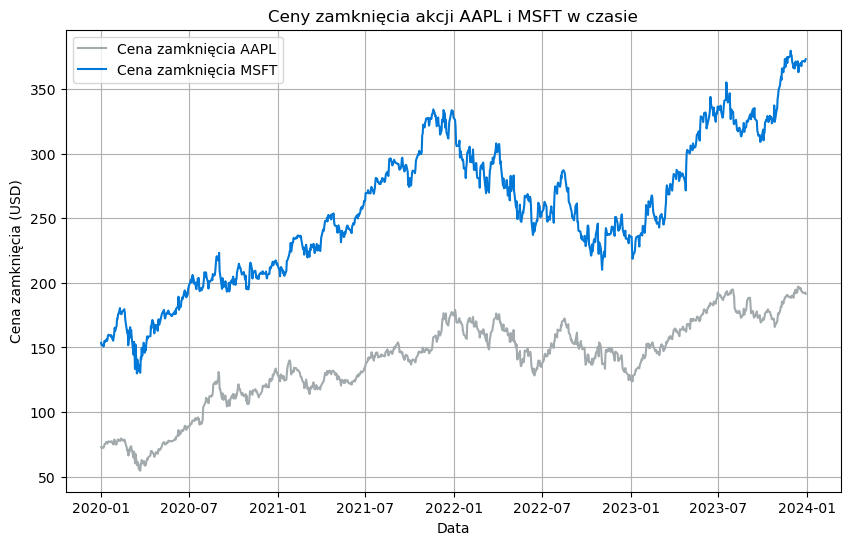

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Close_AAPL"], color='#A2AAAD', label="Cena zamkniƒôcia AAPL")
plt.plot(data.index, data["Close_MSFT"], color='#0078D7', label="Cena zamkniƒôcia MSFT")
plt.xlabel("Data")
plt.ylabel("Cena zamkniƒôcia (USD)")
plt.title("Ceny zamkniƒôcia akcji AAPL i MSFT w czasie")
plt.legend()
plt.grid()
plt.show()

Z wykresu mo≈ºna zauwa≈ºyƒá, ≈ºe obie zmienne (ceny zamkniƒôcia akcji AAPL i MSFT) wykazujƒÖ pewne podobie≈Ñstwa w trendach (wykazujƒÖ og√≥lny trend wzrostowy), co sugeruje, ≈ºe mogƒÖ byƒá skorelowane. Obecno≈õc tendu mo≈ºemy zweryfikowaƒá za pomocƒÖ testu Manna-Kendalla:

In [8]:
trend_test1 = mk.original_test(data['Close_AAPL'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: increasing
Nachylenie: 0.10215111585542154
p-value: 0.0


In [9]:
trend_test2 = mk.original_test(data['Close_MSFT'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: increasing
Nachylenie: 0.16760279162176725
p-value: 0.0


Test potwierdza obecno≈õƒá trednu rosnƒÖcego dla obu szereg√≥w. Zr√≥≈ºnicowanie danych mo≈ºe pom√≥c w usuniƒôciu trendu i sprawieniu, by szeregi czasowe sta≈Çy siƒô stacjonarne (czyli ich statystyki (≈õrednia, wariancja, kowariancja) nie zmienia≈Çy siƒô w czasie).

## Zr√≥≈ºnicowanie szereg√≥w czasowych
Nasze dane sƒÖ nieciƒÖg≈Çe (brakuje weekend√≥w i ≈õwiƒÖt), wiƒôc r√≥≈ºnicowanie bƒôdzie dotyczy≈Ço tylko dni handlowych. Uzupe≈Çnianie brakujƒÖcych dni sztucznymi warto≈õciami (np. przez forward fill) mo≈ºe wprowadziƒá fa≈Çszywe informacje do analizy. W rezultacie uwzglƒôdniamy tylko rzeczywiste zmiany cen w dostƒôpnych datach.

In [10]:
data["diff_aapl"] = data["Close_AAPL"].diff()
data["diff_msft"] = data["Close_MSFT"].diff()
data = data.dropna()

Mo≈ºemy wy≈õwietliƒá podstawowe statystyki otrzymanych szereg√≥w start:

In [11]:
print(data[["diff_aapl","diff_msft"]].describe())

         diff_aapl    diff_msft
count  1005.000000  1005.000000
mean      0.118204     0.218526
std       2.603360     4.724795
min     -10.269295   -22.452484
25%      -1.277176    -2.387589
50%       0.148880     0.248672
75%       1.613174     2.996643
max      11.875122    19.677002


Wnioski:
- ≈örednia dzienna zmiana ceny dla AAPL wynosi 0.12 USD, a dla MSFT 0.21 USD, co sugeruje, ≈ºe MSFT wykazuje wiƒôksze dzienne wzrosty w analizowanym okresie.
- Odchylenie standardowe wynosi 2.65 USD dla AAPL i 4.85 USD dla MSFT, wskazujƒÖc na znacznie wiƒôkszƒÖ zmienno≈õƒá cen akcji MSFT w por√≥wnaniu do AAPL.
- Minimalne dzienne zmiany to -10.52 USD dla AAPL i -23.41 USD dla MSFT, co ≈õwiadczy o istnieniu dni z du≈ºymi spadkami cen.
- Maksymalne dzienne wzrosty wynoszƒÖ 12.00 USD dla AAPL i 19.95 USD dla MSFT, co pokazuje potencjalne znaczƒÖce skoki cen w niekt√≥rych dniach.
- W 25% przypadk√≥w zmiany dzienne AAPL wynosi≈Çy mniej ni≈º -1.30 USD, a dla MSFT mniej ni≈º -2.45 USD.
- Mediana zmian dziennych to 0.15 USD dla AAPL i 0.23 USD dla MSFT, co oznacza, ≈ºe zmiany by≈Çy najczƒô≈õciej bliskie zeru lub nieznacznie dodatnie.
- W 75% przypadk√≥w zmiany dzienne AAPL wynosi≈Çy mniej ni≈º 1.66 USD, a dla MSFT mniej ni≈º 3.06 USD.

Og√≥lnie, akcje MSFT wykazujƒÖ wiƒôkszƒÖ zmienno≈õƒá zar√≥wno w g√≥rƒô, jak i w d√≥≈Ç w por√≥wnaniu do AAPL. Sprawdzimy na wykresie jak zmieni≈Çy siƒô dane:

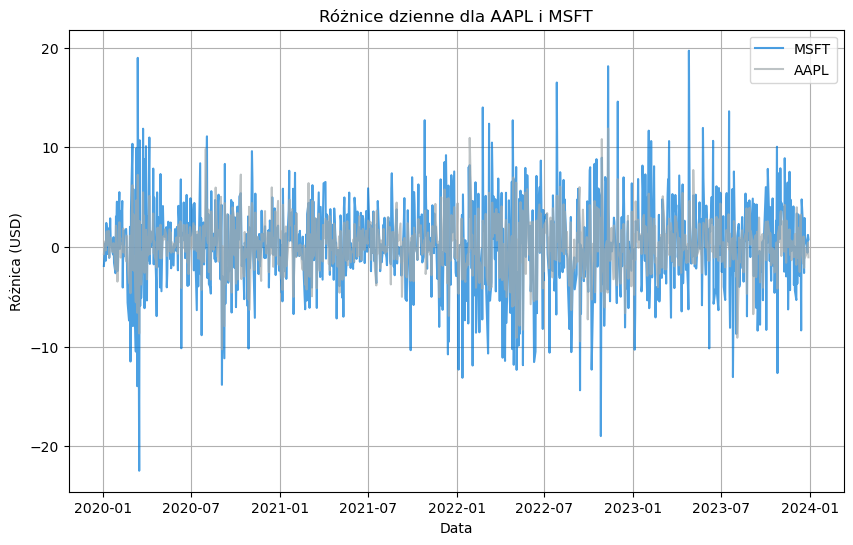

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["diff_msft"], label="MSFT", color="#0078D7", alpha=0.7)
plt.plot(data.index, data["diff_aapl"], label="AAPL", color="#A2AAAD", alpha=0.7)
plt.title("R√≥≈ºnice dzienne dla AAPL i MSFT")
plt.xlabel("Data")
plt.ylabel("R√≥≈ºnica (USD)")
plt.legend()
plt.grid(True)
plt.show()

Na wykresie nie zauwa≈ºamy wyra≈∫nego trendu. Sprawdzimy to za pomocƒÖ testu Manna-Kendalla:

In [13]:
trend_test1 = mk.original_test(data['diff_aapl'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: no trend
Nachylenie: -7.911131126822046e-05
p-value: 0.7519628657959392


In [14]:
trend_test2 = mk.original_test(data['diff_msft'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: no trend
Nachylenie: -6.316242968787246e-05
p-value: 0.8955718674336641


Test potwierdza pozbycie siƒô trendu dla obu szereg√≥w. Mo≈ºemy r√≥wnie≈º przetestowaƒá stacjonarno≈õƒá zr√≥≈ºnicowanych szereg√≥w za pomocƒÖ rozszerzonego testu Dickey-Fullera (ADF):

In [15]:
result1 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result1[1]}")

if result1[1] < 0.05:
    print("Odrzucamy hipotezƒô zerowƒÖ. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezƒô zerowƒÖ. Szereg czasowy jest stacjonarny.


In [16]:
result2 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result2[1]}")

if result2[1] < 0.05:
    print("Odrzucamy hipotezƒô zerowƒÖ. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezƒô zerowƒÖ. Szereg czasowy jest stacjonarny.


Mo≈ºemy odrzuciƒá hipotezƒô zerowƒÖ, oba szeregi strat sƒÖ stacjonarne. Sprawdzimy warto≈õci odstajƒÖce:

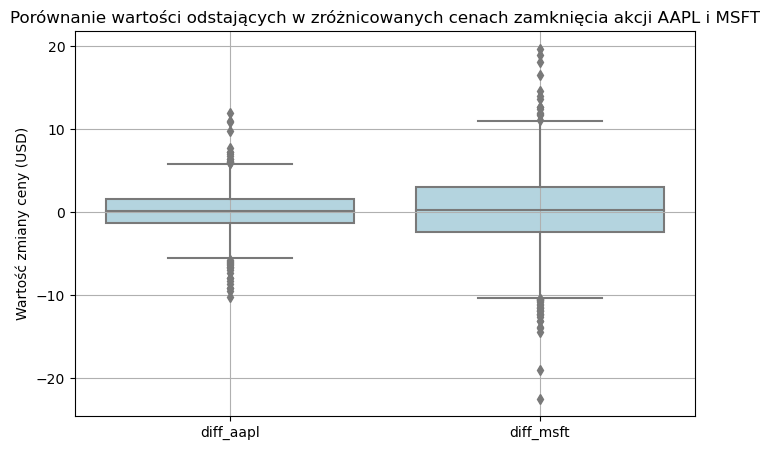

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data[["diff_aapl","diff_msft"]], color='lightblue')
plt.title("Por√≥wnanie warto≈õci odstajƒÖcych w zr√≥≈ºnicowanych cenach zamkniƒôcia akcji AAPL i MSFT")
plt.xlabel("")
plt.ylabel("Warto≈õƒá zmiany ceny (USD)")
plt.grid(True)
plt.show()

- Mediana zmian cen akcji Apple (diff_aapl) jest bliska zeru, co sugeruje, ≈ºe wiƒôkszo≈õƒá zmian cen jest niewielka. Mediana zmian cen akcji Microsoft (diff_msft) jest r√≥wnie≈º bliska zeru.
- Rozstƒôp miƒôdzykwartylowy dla Apple jest mniejszy ni≈º dla Microsoft, co oznacza, ≈ºe zmiany cen akcji Apple sƒÖ mniej zr√≥≈ºnicowane ni≈º zmiany cen akcji Microsoft.
- W obu przypadkach widoczne sƒÖ warto≈õci odstajƒÖce, kt√≥re sƒÖ bardziej liczne w przypadku Microsoft. Warto≈õci te reprezentujƒÖ dni, w kt√≥rych zmiany cen by≈Çy znacznie wiƒôksze ni≈º w pozosta≈Çych dniach.

Policzymy korelacjƒô liniowƒÖ, statystyki Tau Kendalla oraz Rho Spearmana w celu oceny zale≈ºno≈õci pomiƒôdzy zmiennymi.
Korelacja Pearsona mierzy liniowƒÖ zale≈ºno≈õƒá miƒôdzy zmiennymi. Wynik to wsp√≥≈Çczynnik korelacji Pearsona (warto≈õƒá od -1 do 1) i warto≈õƒá p, kt√≥ra ocenia istotno≈õƒá tej korelacji.

In [18]:
pearson_corr, pearson_p = pearsonr(data["diff_aapl"], data["diff_msft"])
print(f"Korelacja Pearsona: {pearson_corr}, p-value: {pearson_p}")

Korelacja Pearsona: 0.7208060413584919, p-value: 7.662852577790345e-162


Warto≈õƒá 0.721 wskazuje na silnƒÖ, dodatniƒÖ zale≈ºno≈õƒá liniowƒÖ miƒôdzy cenami zamkniƒôcia akcji AAPL i MSFT. Warto≈õƒá p jest bardzo ma≈Ça ($2.14 \times 10^{-162}$), co oznacza, ≈ºe zale≈ºno≈õƒá jest statystycznie istotna.

Statystyka Tau Kendalla mierzy monotonicznƒÖ zale≈ºno≈õƒá miƒôdzy zmiennymi na podstawie par por√≥wnywalnych.

In [19]:
kendall_corr, kendall_p = kendalltau(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Tau Kendalla: {kendall_corr}, p-value: {kendall_p}")

Statystyka Tau Kendalla: 0.5581550232416986, p-value: 1.097383041178388e-154


Warto≈õƒá 0.558 wskazuje na umiarkowanƒÖ dodatniƒÖ monotonicznƒÖ zale≈ºno≈õƒá miƒôdzy zmiennymi. Tau Kendalla jest bardziej odporny na warto≈õci odstajƒÖce ni≈º korelacja Pearsona. Bardzo niski poziom p ($1.29 \times 10^{-154}$) wskazuje, ≈ºe zale≈ºno≈õƒá jest istotna.

Statystyka Rho Spearmana mierzy monotonicznƒÖ zale≈ºno≈õƒá na podstawie rang zmiennych.

In [20]:
spearman_corr, spearman_p = spearmanr(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Rho Spearmana: {spearman_corr}, p-value: {spearman_p}")

Statystyka Rho Spearmana: 0.7378622423645812, p-value: 1.9639321123668025e-173


Warto≈õƒá 0.738 wskazuje na silnƒÖ dodatniƒÖ monotonicznƒÖ zale≈ºno≈õƒá miƒôdzy zmiennymi. Rho Spearmana, podobnie jak Tau Kendalla, opiera siƒô na rangach i jest mniej wra≈ºliwy na warto≈õci odstajƒÖce. Bardzo ma≈Ça warto≈õƒá p ($2.83 \times 10^{-173}$) wskazuje na istotno≈õƒá statystycznƒÖ tej zale≈ºno≈õci.

Wnioski:
- Wszystkie trzy miary korelacji wskazujƒÖ, ≈ºe istnieje statystycznie istotna zale≈ºno≈õƒá miƒôdzy zmianami warto≈õci diff_aapl i diff_msft.
- Korelacja Pearsona sugeruje, ≈ºe zale≈ºno≈õƒá liniowa jest silna (0.721). Tau Kendalla i Spearmana wskazujƒÖ na umiarkowanƒÖ i silnƒÖ zale≈ºno≈õƒá monotonicznƒÖ.

## Dopasowanie rozk≈Çad√≥w

Za pomocƒÖ histogram√≥w mo≈ºemy zobaczyƒá, jak rozk≈ÇadajƒÖ siƒô warto≈õci w zr√≥≈ºnicowanych szeregach cen akcji AAPL i MSFT:

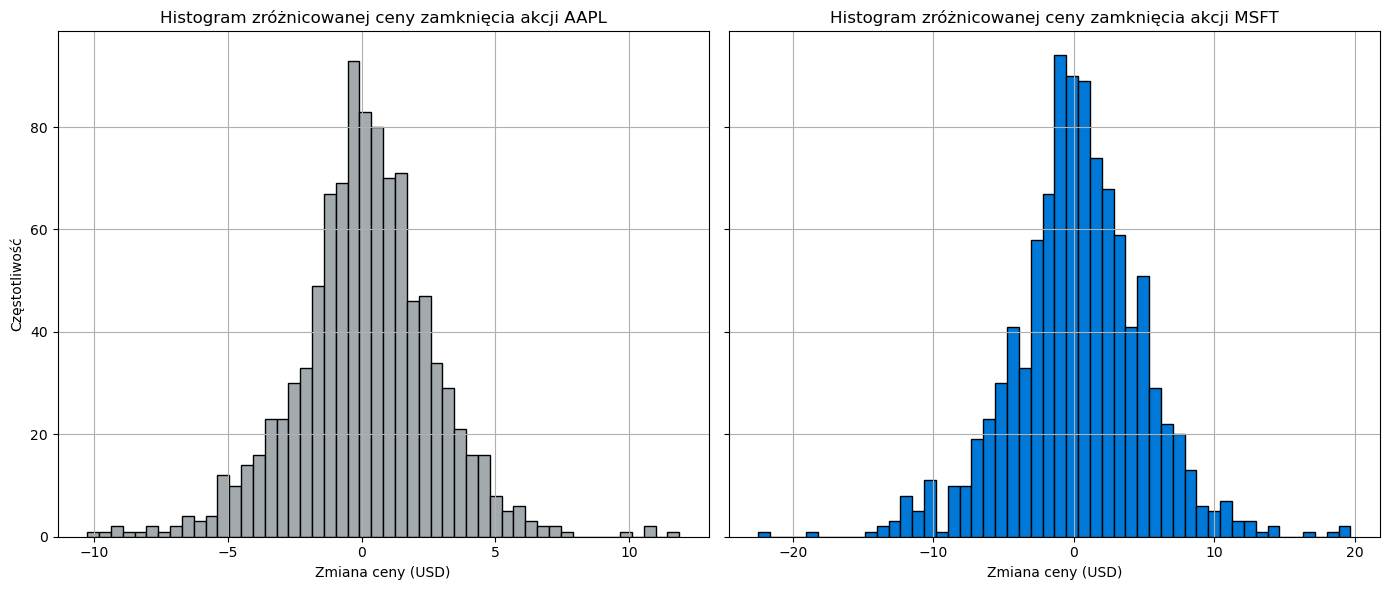

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].hist(data["diff_aapl"], bins=50, edgecolor='k', color='#A2AAAD')
axes[0].set_title("Histogram zr√≥≈ºnicowanej ceny zamkniƒôcia akcji AAPL")
axes[0].set_xlabel("Zmiana ceny (USD)")
axes[0].set_ylabel("Czƒôstotliwo≈õƒá")
axes[0].grid(True)

axes[1].hist(data["diff_msft"], bins=50, edgecolor='k', color='#0078D7')
axes[1].set_title("Histogram zr√≥≈ºnicowanej ceny zamkniƒôcia akcji MSFT")
axes[1].set_xlabel("Zmiana ceny (USD)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

- Oba histogramy majƒÖ kszta≈Çt zbli≈ºony do dzwonu, co sugeruje, ≈ºe zmiany cen mogƒÖ pochodziƒá z rozk≈Çad√≥w normalnych.
- Histogram dla AAPL jest bardziej symetryczny i skoncentrowany wok√≥≈Ç zera, co oznacza, ≈ºe zmiany ceny zamkniƒôcia akcji AAPL sƒÖ bardziej stabilne i mniej zmienne.
- Histogram dla MSFT jest r√≥wnie≈º zbli≈ºony do rozk≈Çadu normalnego, ale ma nieco wiƒôkszƒÖ zmienno≈õƒá w por√≥wnaniu do AAPL, co mo≈ºe sugerowaƒá wiƒôkszƒÖ niestabilno≈õƒá cen akcji MSFT.

Przetestujemy, czy dane pochodzƒÖ z rozk≈Çadu normalnego za pomocƒÖ testu Shapiro-Wilka:

In [22]:
stat, p_value = shapiro(data["diff_aapl"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogƒÖ pochodziƒá z rozk≈Çadu normalnego.")
else:
    print("Odrzucamy hipotezƒô. Dane nie sƒÖ zgodne z rozk≈Çadem normalnym.")

Statystyka testowa: 0.9821599721908569
p-value: 9.46976164151181e-10
Odrzucamy hipotezƒô. Dane nie sƒÖ zgodne z rozk≈Çadem normalnym.


In [23]:
stat, p_value = shapiro(data["diff_msft"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogƒÖ pochodziƒá z rozk≈Çadu normalnego.")
else:
    print("Odrzucamy hipotezƒô. Dane nie sƒÖ zgodne z rozk≈Çadem normalnym.")

Statystyka testowa: 0.9836159348487854
p-value: 3.400359327443425e-09
Odrzucamy hipotezƒô. Dane nie sƒÖ zgodne z rozk≈Çadem normalnym.


Oba szeregi nie pochodzƒÖ z rozk≈Çadu normalnego. Czy pochodzƒÖ z rozk≈Çadu t-Studenta? Zastosujemy test Ko≈Çmogorowa-Smirnowa do oceny zgodno≈õci danych z rozk≈Çadem t-Studenta:

In [24]:
params = t.fit(data["diff_aapl"])

stat, p_value = kstest(data["diff_aapl"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogƒÖ pochodziƒá z rozk≈Çadu t-Studenta.")
else:
    print("Odrzucamy hipotezƒô. Dane nie sƒÖ zgodne z rozk≈Çadem t-Studenta.")

Statystyka testowa: 0.016214608309635434
p-value: 0.9503492775076191
Brak podstaw do odrzucenia hipotezy. Dane mogƒÖ pochodziƒá z rozk≈Çadu t-Studenta.


In [25]:
params = t.fit(data["diff_msft"])

stat, p_value = kstest(data["diff_msft"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogƒÖ pochodziƒá z rozk≈Çadu t-Studenta.")
else:
    print("Odrzucamy hipotezƒô. Dane nie sƒÖ zgodne z rozk≈Çadem t-Studenta.")

Statystyka testowa: 0.021022929205848584
p-value: 0.7577903550694564
Brak podstaw do odrzucenia hipotezy. Dane mogƒÖ pochodziƒá z rozk≈Çadu t-Studenta.


Zatem oba szeregi start mogƒÖ pochodziƒá z rozk≈Çadu t-Studenta.

## Dopasowanie kopu≈Ç - sklarpy (b≈ÇƒÖd z kopu≈ÇƒÖ Claytona)
Dopasujemy piƒôƒá kopu≈Ç i ocenimy ich dopasowanie:
- eliptyczne - t-Studenta, normalna,
- archimedejskie - Gumbela, Claytona, Franka.

Sprawdzimy jak wyglƒÖda nasz rozk≈Çad ≈ÇƒÖczny:

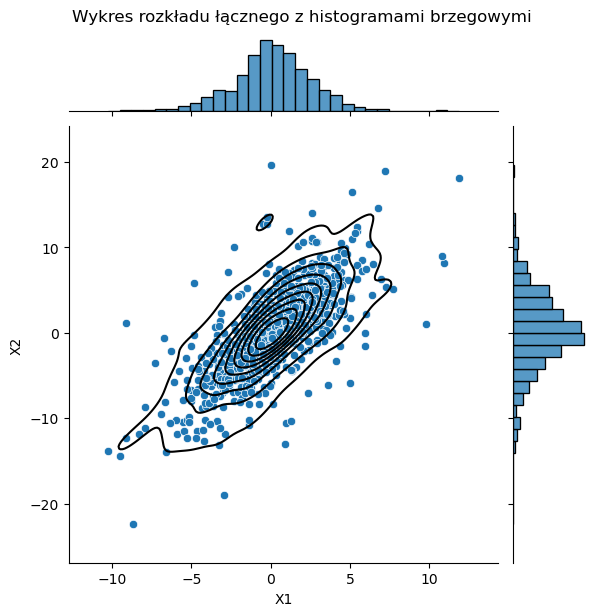

In [26]:
g = sns.jointplot(x="diff_aapl", y="diff_msft", data=data, kind="scatter", marginal_kws=dict(bins=30, fill=True))

g.fig.suptitle("Wykres rozk≈Çadu ≈ÇƒÖcznego z histogramami brzegowymi", y=1.02)
sns.kdeplot(data=data, x="diff_aapl", y="diff_msft", color="black")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

Kontury majƒÖ kszta≈Çt eliptyczny i sƒÖ skoncentrowane wok√≥≈Ç ≈õrodka, co sugeruje, ≈ºe rozk≈Çad jest symetryczny i dzwonowaty.

Poniewa≈º rozk≈Çady brzegowe mogƒÖ pochodziƒá z rozk≈Çadu t-Studenta, przekszta≈Çcimy szeregi na dystrybuanty brzegowe dopasowujƒÖc rozk≈Çady t-Studenta:

In [27]:
fitted_marginals = {
    0: student_t.fit(data["diff_aapl"]),
    1: student_t.fit(data["diff_msft"])
}

data["u1"] = fitted_marginals[0].cdf(np.array(data["diff_aapl"]))
data["u2"] = fitted_marginals[1].cdf(np.array(data["diff_msft"]))

### Kopu≈Ça T-Studenta

In [28]:
student_t_fit = student_t_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.DataFrame({
    "Copula": ["Student-t"],
    "Log-Likelihood": [student_t_fit.loglikelihood()],
    "AIC": [student_t_fit.aic()],
    "BIC": [student_t_fit.bic()]
})

print(results.loc[0])

Copula              Student-t
Log-Likelihood   -3611.296811
AIC               7238.593623
BIC               7277.895565
Name: 0, dtype: object


In [29]:
print("Liczba stopni swobody (dof):", student_t_fit.copula_params.dof) 
print("Macierz kowariancji (cov):", student_t_fit.copula_params.cov) 

Liczba stopni swobody (dof): 100.0
Macierz kowariancji (cov): [[1.02040816 0.7843497 ]
 [0.7843497  1.02040816]]


### Kopu≈Ça Gaussa

In [30]:
gaussian_fit = gaussian_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gaussian"],
        "Log-Likelihood": [gaussian_fit.loglikelihood()],
        "AIC": [gaussian_fit.aic()],
        "BIC": [gaussian_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[1])

Copula               Gaussian
Log-Likelihood   -3615.902927
AIC               7245.805854
BIC               7280.195054
Name: 1, dtype: object


In [31]:
print("Macierz kowariancji (cov):", gaussian_fit.copula_params.cov)

Macierz kowariancji (cov): [[1.        0.7686627]
 [0.7686627 1.       ]]


### Kopu≈Ça Claytona - z≈Ça, niedobra

In [32]:
clayton_fit = clayton_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals, verbose=True)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Clayton"],
        "Log-Likelihood": [clayton_fit.loglikelihood()],
        "AIC": [clayton_fit.aic()],
        "BIC": [clayton_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[2])

Copula                Clayton
Log-Likelihood    1339.086519
AIC              -2662.173038
BIC              -2622.871095
Name: 2, dtype: object


### Kopu≈Ça Gumbela

In [33]:
gumbel_fit = gumbel_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gumbel"],
        "Log-Likelihood": [gumbel_fit.loglikelihood()],
        "AIC": [gumbel_fit.aic()],
        "BIC": [gumbel_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[3])

Copula                 Gumbel
Log-Likelihood   -2594.319443
AIC               5204.638886
BIC               5243.940828
Name: 3, dtype: object


### Kopu≈Ça Franka

In [34]:
frank_fit = frank_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Frank"],
        "Log-Likelihood": [frank_fit.loglikelihood()],
        "AIC": [frank_fit.aic()],
        "BIC": [frank_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[4])

Copula                  Frank
Log-Likelihood   -2571.220312
AIC               5158.440624
BIC               5197.742567
Name: 4, dtype: object


Mo≈ºemy oceniƒá dopasowanie kopu≈Ç za pomocƒÖ miar:
- Log-Likelihood: jest to miara, kt√≥ra ocenia, jak dobrze model kopu≈Çy pasuje do danych. Wy≈ºsza warto≈õƒá log-likelihood wskazuje na lepsze dopasowanie modelu do danych.
- AIC (Akaike Information Criterion): AIC uwzglƒôdnia zar√≥wno dopasowanie modelu, jak i jego z≈Ço≈ºono≈õƒá. Ni≈ºsza warto≈õƒá AIC wskazuje na lepszy model, poniewa≈º oznacza lepsze dopasowanie przy mniejszej z≈Ço≈ºono≈õci.
- BIC (Bayesian Information Criterion): BIC r√≥wnie≈º uwzglƒôdnia dopasowanie modelu i jego z≈Ço≈ºono≈õƒá, ale karze bardziej za z≈Ço≈ºono≈õƒá ni≈º AIC. Ni≈ºsza warto≈õƒá BIC wskazuje na lepszy model.
- 
Zatem ni≈ºsze warto≈õci AIC i BIC oraz wy≈ºsza warto≈õƒá log-likelihood wskazujƒÖ na lepsze dopasowanie kopu≈Çy do danych.

In [35]:
print("\nZestawienie wynik√≥w dla wszystkich kopu≈Ç:")
print(results)


Zestawienie wynik√≥w dla wszystkich kopu≈Ç:
      Copula  Log-Likelihood          AIC          BIC
0  Student-t    -3611.296811  7238.593623  7277.895565
1   Gaussian    -3615.902927  7245.805854  7280.195054
2    Clayton     1339.086519 -2662.173038 -2622.871095
3     Gumbel    -2594.319443  5204.638886  5243.940828
4      Frank    -2571.220312  5158.440624  5197.742567


Wyniki dla kopu≈Çy Claytona znacznie r√≥≈ºniƒÖ siƒô od pozosta≈Çych (w por√≥wnaniu do pozosta≈Çych wyglƒÖdajƒÖ jak b≈ÇƒÖd lub nadmierne dopasowanie do danych). Przyjmiemy, ≈ºe wynika to z b≈Çƒôdu w impementacji tej kopu≈Çy. Aby wybraƒá najlepszƒÖ kopu≈Çƒô bƒôdziemy patrzeƒá na wyniki testu BIC. Posortujemy tabelƒô rosnƒÖco wzglƒôdem kolumny BIC, wiƒôc najlepsza kopu≈Ça bƒôdzie na samej g√≥rze:

In [36]:
kopules = results.copy()

In [37]:
results_sorted = results.sort_values(by="BIC", ascending=True).reset_index(drop=True)

print("\nTabela z wynikami (posortowana wed≈Çug BIC):")
print(results_sorted)


Tabela z wynikami (posortowana wed≈Çug BIC):
      Copula  Log-Likelihood          AIC          BIC
0    Clayton     1339.086519 -2662.173038 -2622.871095
1      Frank    -2571.220312  5158.440624  5197.742567
2     Gumbel    -2594.319443  5204.638886  5243.940828
3  Student-t    -3611.296811  7238.593623  7277.895565
4   Gaussian    -3615.902927  7245.805854  7280.195054


Odrzucamy kopu≈Çƒô Claytona. Najlepsza kopu≈Ça wedlug BIC to kopu≈Ça Franka. Sprawdzimy dopasowanie kopu≈Ç za pomocƒÖ wykres√≥w, generujƒÖc z kopu≈Ç przyk≈Çadowe pr√≥bki i por√≥wnujƒÖc je z rozk≈Çadem ≈ÇƒÖcznym oryginalnych danych. Mo≈ºemy wygenerowaƒá pr√≥bki za pomocƒÖ metody rvs():

In [38]:
student_t_samples = student_t_fit.rvs(len(data))
gaussian_samples = gaussian_fit.rvs(len(data))
clayton_samples = clayton_fit.rvs(len(data))
gumbel_samples = gumbel_fit.rvs(len(data))
frank_samples = frank_fit.rvs(len(data))

Rysujemy wykresy rozk≈Çadu dwuwymiarowego uzywajƒÖc sns.kdeplot(x,y). Punkty na wykresie oznaczajƒÖ dane oryginalne, natomiast linie zosta≈Çy wygenerowane na podstawie pr√≥bek z dopasowanych kopu≈Ç:

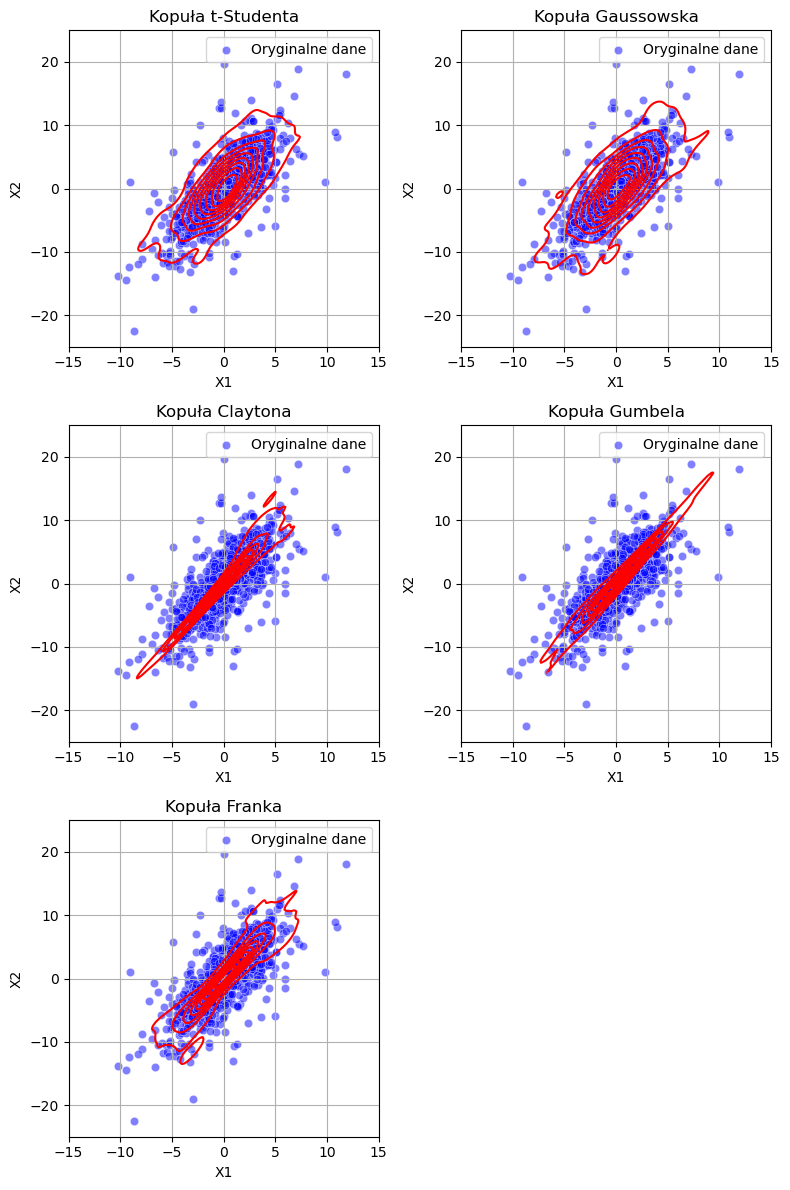

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
axes = ax.flatten()

copula_samples = [
    (student_t_samples, "Kopu≈Ça t-Studenta"),
    (gaussian_samples, "Kopu≈Ça Gaussowska"),
    (clayton_samples, "Kopu≈Ça Claytona"),
    (gumbel_samples, "Kopu≈Ça Gumbela"),
    (frank_samples, "Kopu≈Ça Franka")
]

for i, (samples, title) in enumerate(copula_samples):
    sns.scatterplot(
        x=data["diff_aapl"], y=data["diff_msft"],
        ax=axes[i], color="blue", alpha=0.5, label="Oryginalne dane"
    )
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=axes[i], color="red")
    axes[i].set_title(title)
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].legend()
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-25, 25)
    axes[i].grid(True)

axes[-1].axis("off")

plt.tight_layout()
plt.show()

1. Kopu≈Ça t-Studenta dobrze radzi sobie z modelowaniem silnych zale≈ºno≈õci w ogonie rozk≈Çadu. Kszta≈Çt kopu≈Çy pokazuje, ≈ºe elipsa nie jest ani bardzo wyd≈Çu≈ºona (co wskazywa≈Çoby na silnƒÖ zale≈ºno≈õƒá), ani bardzo okrƒÖg≈Ça (co oznacza≈Çoby brak zale≈ºno≈õci).
2. Kopu≈Ça Gaussowska modeluje zale≈ºno≈õci w spos√≥b bardziej symetryczny, co oznacza, ≈ºe zale≈ºno≈õƒá miƒôdzy zmiennymi jest r√≥wnomiernie roz≈Ço≈ºona. Mo≈ºe nie radziƒá sobie dobrze z modelowaniem zale≈ºno≈õci w ogonach (ekstremalne warto≈õci). Eliptyczny kszta≈Çt wskazuje na r√≥wnomiernƒÖ korelacjƒô.
3. Kopu≈Ça Claytona dopasowuje siƒô do liniowego trendu.
4. Kopu≈Ça Gumbela dopasowuje siƒô do liniowego trendu.
5. Kopu≈Ça Franka modeluje zale≈ºno≈õci w spos√≥b mniej eliptyczny ni≈º Gaussowska. Nie jest szczeg√≥lnie skoncentrowana na ogonach rozk≈Çadu, co czyni jƒÖ bardziej uniwersalnƒÖ dla umiarkowanych zale≈ºno≈õci. Na wykresie widoczna jest r√≥wnomierna struktura zale≈ºno≈õci.

Wyodrƒôbnimy parametry do p√≥≈∫niejszego por√≥wnania, jak poradzi sobie copulas z thetami, kt√≥re wybra≈Ço sklarpy:

In [40]:
params = {
    "Copula": ["Clayton", "Gumbel", "Frank"],
    "Parametr Theta": [
        #gaussian_fit.correlation,
        clayton_fit.copula_params.theta,
        gumbel_fit.copula_params.theta,
        frank_fit.copula_params.theta
    ]
}

params_df = pd.DataFrame(params)
print(params_df)

    Copula  Parametr Theta
0  Clayton       28.991157
1   Gumbel       10.273737
2    Frank       31.689794


## Copulas - nie ma kopu≈Çy t-Studenta dla rozk≈Çad√≥w dwuwymiarowych
Mo≈ºemy wykorzystaƒá wbudowanƒÖ metodƒô select_univariate() aby dopasowaƒá najlepsze rozk≈Çady brzegowe:

In [41]:
candidates = [
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate
]

best_model1 = select_univariate(data["diff_aapl"], candidates)
best_model2 = select_univariate(data["diff_msft"], candidates)
print(f"Najlepszy rozk≈Çad brzegowy AAPL: {type(best_model1).__name__}")
print(f"Najlepszy rozk≈Çad brzegowy MSFT: {type(best_model2).__name__}")

Najlepszy rozk≈Çad brzegowy AAPL: StudentTUnivariate
Najlepszy rozk≈Çad brzegowy MSFT: StudentTUnivariate


Poniewa≈º rozk≈Çady brzegowe mogƒÖ pochodziƒá z rozk≈Çadu t-Studenta, przekszta≈Çcimy szeregi na dystrybuanty brzegowe dopasowujƒÖc rozk≈Çady t-Studenta:

In [42]:
marginal_aapl = StudentTUnivariate()
marginal_aapl.fit(data["diff_aapl"])
marginal_msft = StudentTUnivariate()
marginal_msft.fit(data["diff_msft"])

data["u1"] = marginal_aapl.cdf(data["diff_aapl"])
data["u2"] = marginal_msft.cdf(data["diff_msft"])
print(data[["u1", "u2"]].head())

                  u1        u2
Date                          
2020-01-03  0.348054  0.294176
2020-01-06  0.576105  0.511327
2020-01-07  0.410697  0.339524
2020-01-08  0.676031  0.700018
2020-01-09  0.735777  0.657655


W pƒôtli dopasujemy kopu≈Çy Gaussa, Claytona, Franka i Gumbela (w pakiecie copulas nie ma kopu≈Çy t-Studenta dla rozk≈Çad√≥w dwuwymiarowych, nie ma te≈º wbudowanych funkcji liczƒÖcych log-likelihood, AIC i BIC):

In [43]:
data_u = data[["u1", "u2"]].to_numpy()

copula_classes = [GaussianMultivariate, Clayton, Gumbel, Frank]
results = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)

    # Log-likelihood
    pdf_values = copula.probability_density(data_u)
    log_likelihood = np.sum(np.log(pdf_values))

    if isinstance(copula, GaussianMultivariate):
        # GaussianMultivariate: liczba parametr√≥w korelacji + liczba parametr√≥w brzegowych
        d = data_u.shape[1]  # Wymiar danych (liczba zmiennych)
        num_correlation_params = d * (d - 1) / 2  # Liczba niezale≈ºnych element√≥w w macierzy korelacji
        num_univariate_params = len(copula.univariates)  # Liczba dystrybucji brzegowych
        num_params = num_correlation_params + num_univariate_params
    else:
        # Clayton, Frank, Gumbel: 1 parametr theta
        num_params = 1

    n = len(data_u)

    # AIC i BIC
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(n)

    results.append({
        'Copula': copula_class.__name__,
        'Num_params': num_params,
        'Log-Likelihood': log_likelihood,
        'AIC': aic,
        'BIC': bic
    })

Wyniki mo≈ºemy zestawiƒá w tabeli:

In [44]:
results = pd.DataFrame(results)
print(results)

                 Copula  Num_params  Log-Likelihood          AIC          BIC
0  GaussianMultivariate         3.0    -2534.527362  5075.054724  5089.792953
1               Clayton         1.0      304.364135  -606.728269  -601.815526
2                Gumbel         1.0      374.963185  -747.926370  -743.013628
3                 Frank         1.0      409.988001  -817.976002  -813.063259


Aby wybraƒá najlepszƒÖ kopu≈Çƒô bƒôdziemy patrzeƒá na wyniki testu BIC. Posortujemy tabelƒô rosnƒÖco wzglƒôdem kolumny BIC, wiƒôc najlepsza kopu≈Ça bƒôdzie na samej g√≥rze (im ni≈ºszy wynik BIC tym lepiej):

In [45]:
results_sorted = results.sort_values(by="BIC", ascending=True).reset_index(drop=True)

print("\nTabela z wynikami (posortowana wed≈Çug BIC):")
print(results_sorted)


Tabela z wynikami (posortowana wed≈Çug BIC):
                 Copula  Num_params  Log-Likelihood          AIC          BIC
0                 Frank         1.0      409.988001  -817.976002  -813.063259
1                Gumbel         1.0      374.963185  -747.926370  -743.013628
2               Clayton         1.0      304.364135  -606.728269  -601.815526
3  GaussianMultivariate         3.0    -2534.527362  5075.054724  5089.792953


1. Kopu≈Ça Franka jest najlepsza. OsiƒÖga najwy≈ºszƒÖ warto≈õƒá log-likelihood (409.54). Ma najni≈ºsze warto≈õci AIC (-817.07) i BIC (-812.16), co wskazuje na najlepsze dopasowanie z uwzglƒôdnieniem prostoty modelu. Jest najbardziej uniwersalna i dobrze radzi sobie z modelowaniem umiarkowanych zale≈ºno≈õci.
2. Gumbel jest drugim najlepszym modelem, ale znacznie gorszym od Franka. Mo≈ºe byƒá odpowiednia, je≈õli dane charakteryzujƒÖ siƒô silnymi zale≈ºno≈õciami w g√≥rnym ogonie rozk≈Çadu.
3. Clayton nie radzi sobie dobrze z danymi w tej analizie, co sugeruje, ≈ºe dane nie zawierajƒÖ istotnych zale≈ºno≈õci w dolnym ogonie.
4. Gaussian Multivariate jest wyra≈∫nie najgorsza. Ekstremalnie niskie log-likelihood i bardzo wysokie warto≈õci AIC oraz BIC wskazujƒÖ, ≈ºe ta kopu≈Ça nie odwzorowuje danych w ≈ºaden spos√≥b zgodny z ich strukturƒÖ. Wysokie warto≈õci AIC i BIC wskazujƒÖ na to, ≈ºe model mo≈ºe byƒá nadmiernie skomplikowany w stosunku do danych, kt√≥re modeluje. Mo≈ºliwe, ≈ºe wynika to ze sposobu implementacji kopu≈Çy - GaussianMultivariate jest og√≥lnƒÖ kopu≈ÇƒÖ wielowymiarowƒÖ, kt√≥ra mo≈ºe byƒá mniej efektywna w modelowaniu danych o prostszej (dwuwymiarowej) strukturze.

Mo≈ºemy sprawdziƒá jakƒÖ najlepszƒÖ kopu≈Çƒô wy≈Çoni metoda select_copula() (wybiera tylko spo≈õr√≥d kopu≈Ç dla rozk≈Çad√≥w dwuwymiarowych, czyli Clayton, Frank i Gumbel):

In [46]:
best_copula = select_copula(data_u)
print(f"Best Copula: {best_copula.__class__.__name__}")

Best Copula: Clayton


Wybra≈Ço kopu≈Çƒô Claytona, ale patrzƒÖc na wyniki BIC nie jest to najlepszy wyb√≥r.

Wylosujemy pr√≥bki z dopasowanych kopu≈Ç aby zwizualizowaƒá kopu≈Çy:

In [47]:
data_u = data[["u1", "u2"]].to_numpy()

copula_classes = [GaussianMultivariate, Clayton, Frank, Gumbel]
copula_samples = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)
    if copula_class == GaussianMultivariate:
        samples_df = copula.sample(num_rows=len(data_u))
    else:
        samples = copula.sample(n_samples=len(data_u))
        samples_df = pd.DataFrame(samples, columns=[0, 1])
    copula_samples.append((samples_df, copula_class.__name__))

Poniewa≈º wylosowone pr√≥bki nale≈ºƒÖ do przedzia≈Çu (0,1), przeskalujemy je z powrotem do warto≈õci rzeczywistych:

In [48]:
samples_real = []

for samples_df, title in copula_samples:
    samples_real_aapl = marginal_aapl.ppf(samples_df[0])
    samples_real_msft = marginal_msft.ppf(samples_df[1])
    
    # ≈ÅƒÖczenie wynik√≥w w jednƒÖ ramkƒô danych
    samples_real_df = pd.DataFrame({
        "X1": samples_real_aapl,
        "X2": samples_real_msft
    })
    
    samples_real.append((samples_real_df, title))

Mo≈ºemy por√≥wnaƒá pr√≥bki wygenerowane z dopasowanych kopu≈Ç (czerwone linie) z danymi oryginalnymi (niebieskie kropki):

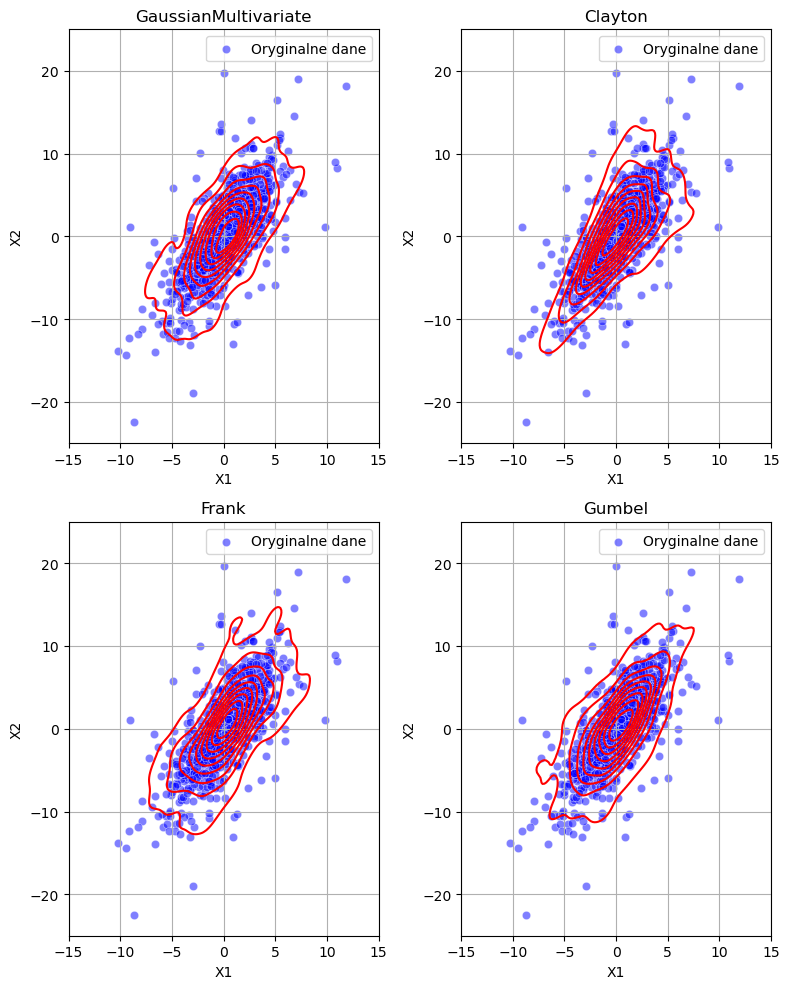

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(8, 10))
axes = ax.flatten()

for i, (samples_real_df, title) in enumerate(samples_real):
    sns.scatterplot(
        x=data["diff_aapl"], y=data["diff_msft"],
        ax=axes[i], color="blue", alpha=0.5, label="Oryginalne dane"
    )
    sns.kdeplot(x=samples_real_df["X1"], y=samples_real_df["X2"], ax=axes[i], color="red")
    axes[i].set_title(title)
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].legend()
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-25, 25)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Wszystkie kopu≈Çy wyglƒÖdajƒÖ dosyƒá podobnie, lecz ka≈ºda kopu≈Ça dobrze odwzorowuje inne aspekty zale≈ºno≈õci. Gaussian Multivariate jest og√≥lna (z tym, ≈ºe numeryczne wyniki sƒÖ podejrzane), Clayton skupia siƒô na dolnych warto≈õciach, Gumbel na wysokich warto≈õciach, a Frank jest najbardziej neutralna.

---

## Parametry theta - por√≥wnanie
Parametry kopu≈Ç (Copulas):

In [50]:
results2 = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)

    # Wyodrƒôbnianie parametr√≥w
    if isinstance(copula, GaussianMultivariate):
        correlation_matrix = copula.correlation
        params = {
            'correlation_matrix': correlation_matrix
        }
    else:
        theta = copula.theta
        params = {'theta': theta}

    results2.append({
        'Copula': copula_class.__name__,
        'Params': params
    })

# Tworzenie tabeli
params_df2 = pd.DataFrame(results2)
print(params_df2) # parametry dopasowanych kopu≈Ç z Copulas

                 Copula                          Params
0  GaussianMultivariate  {'correlation_matrix': [0, 1]}
1               Clayton   {'theta': 2.5264744541704784}
2                 Frank    {'theta': 6.907463392562251}
3                Gumbel   {'theta': 2.2632372270852392}


Parametry kopu≈Ç (Sklarpy):

In [51]:
print(params_df) # parametry dopasowanych kopu≈Ç z Sklarpy

    Copula  Parametr Theta
0  Clayton       28.991157
1   Gumbel       10.273737
2    Frank       31.689794


Por√≥wnujƒÖc parametr $\theta$ dopasowanych kopu≈Ç archimedejskich z Sklarpy i Copulas widzimy sporƒÖ r√≥≈ºnicƒô. NajlepszƒÖ kopu≈ÇƒÖ w obu przypadkach by≈Ça kopu≈Ça Franka. Sprawdzimy, czy otrzymamy te same wyniki AIC/BIC, je≈õli dla kopu≈Çy Franka z obu bibliotek przyjmiemy to samo $\theta$.

In [52]:
# Kopu≈Ça Franka ze sklarpy, musimy podaƒá theta z copulas
frank = frank_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals, theta=6.909811222142677)

wyniki = pd.DataFrame({
    "Copula": ["Frank"],
    "Log-Likelihood": [frank.loglikelihood()],
    "AIC": [frank.aic()],
    "BIC": [frank.bic()],
    "Theta": [frank.copula_params.theta]
})
print(wyniki) # kopu≈Ça Sklarpy z narzuconym theta

  Copula  Log-Likelihood          AIC          BIC      Theta
0  Frank    -2571.220312  5158.440624  5197.742567  31.689794


Jak widaƒá narzucona $\theta$ zosta≈Ça zastƒÖpiona dopasowanym parametrem. W sklarpy nie da siƒô podaƒá warto≈õci $\theta$ bez dopasowania kopu≈Çy.

In [53]:
print(results_sorted.loc[0]) # kopu≈Ça Copulas
print()
print(params_df2.loc[2]["Params"])

Copula                 Frank
Num_params               1.0
Log-Likelihood    409.988001
AIC              -817.976002
BIC              -813.063259
Name: 0, dtype: object

{'theta': 6.907463392562251}


Spr√≥bujemy narzuciƒá $\theta$ z kopu≈Çy Franka Sklarpy kopule Franka z Copulas.

In [54]:
frank_copulas = Frank()

frank_copulas.fit(data_u)
frank_copulas.theta = 32.147256

# Obliczenie gƒôsto≈õci prawdopodobie≈Ñstwa (PDF)
pdf_values = frank_copulas.probability_density(data_u)

# Log-likelihood
log_likelihood = np.sum(np.log(pdf_values))
num_params = 1
n = len(data_u)

# AIC i BIC
aic = -2 * log_likelihood + 2 * num_params
bic = -2 * log_likelihood + num_params * np.log(n)

# Wy≈õwietlenie wynik√≥w
wyniki2 = pd.DataFrame({
    'Copula': ['Frank'],
    'Theta': [frank_copulas.theta],
    'Log-Likelihood': [log_likelihood],
    'AIC': [aic],
    'BIC': [bic]
})

print(wyniki2) # kopu≈Ça Copulas z narzuconym theta

  Copula      Theta  Log-Likelihood  AIC  BIC
0  Frank  32.147256            -inf  inf  inf


In [55]:
print(kopules.loc[4]) # kopu≈Ça Sklarpy

Copula                  Frank
Log-Likelihood   -2571.220312
AIC               5158.440624
BIC               5197.742567
Name: 4, dtype: object


W kopule Franka z Copulas z narzuconƒÖ $\theta$=32.147256 (du≈ºo wy≈ºsza warto≈õƒá ni≈º dopasowana 6.909811) mamy wyniki w niesko≈Ñczono≈õciach. Im wiƒôksze $\theta$ tym silniejsze zale≈ºno≈õci modeluje kopu≈Ça. Nie da siƒô por√≥wnaƒá implementacji z tych dw√≥ch bibliotek. Trzeba siƒô zdecydowaƒá na jednƒÖ bibliotekƒô.

---

## Test Mardia
Mo≈ºemy wykonaƒá test na wielowymiarowƒÖ normalno≈õƒá:

In [56]:
mardia_test = multivariate_normality(data[["diff_aapl", "diff_msft"]], alpha=0.05)

print("Test Mardia:")
print(mardia_test)

Test Mardia:
HZResults(hz=11.058750172183926, pval=1.721878102347852e-24, normal=False)


Niska warto≈õƒá p oznacza, ≈ºe mo≈ºemy odrzuciƒá hipotezƒô zerowƒÖ, czyli za≈Ço≈ºenie, ≈ºe dane sƒÖ wielowymiarowo normalne.

Narysujemy elipsƒô ufno≈õci:

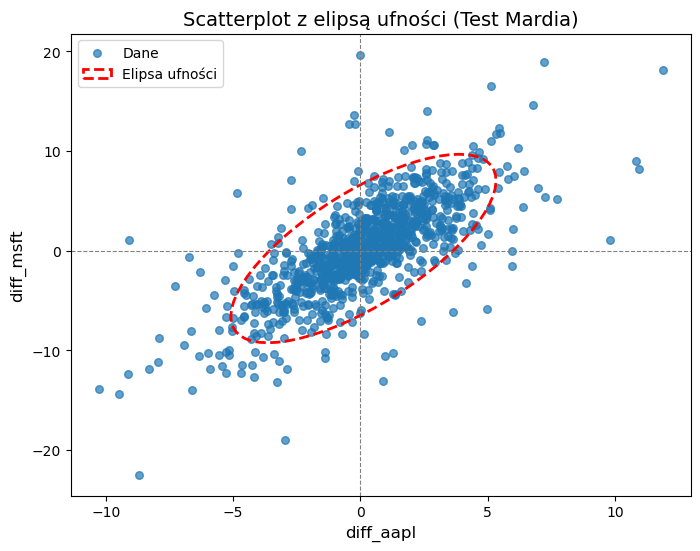

In [57]:
# Funkcja do rysowania elipsy ufno≈õci
def plot_with_confidence_ellipse(data_x, data_y, ax, n_std=2.0, **kwargs):
    if len(data_x) != len(data_y):
        raise ValueError("data_x i data_y muszƒÖ mieƒá tƒô samƒÖ d≈Çugo≈õƒá")
    
    # Obliczanie ≈õredniej i macierzy kowariancji
    mean_x = np.mean(data_x)
    mean_y = np.mean(data_y)
    cov_matrix = np.cov(data_x, data_y)
    
    # Warto≈õci w≈Çasne i wektory w≈Çasne
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # KƒÖt elipsy
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Wymiary elipsy
    width, height = 2 * n_std * np.sqrt(eigenvalues)
    
    # Dodanie elipsy do wykresu
    ellipse = Ellipse((mean_x, mean_y), width, height, angle, **kwargs)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(data["diff_aapl"], data["diff_msft"], s=30, alpha=0.7, label="Dane")

plot_with_confidence_ellipse(
    data["diff_aapl"], data["diff_msft"], ax, n_std=2.0,
    edgecolor='red', facecolor='none', linewidth=2, linestyle='--', label="Elipsa ufno≈õci"
)

ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_title("Scatterplot z elipsƒÖ ufno≈õci (Test Mardia)", fontsize=14)
ax.set_xlabel("diff_aapl", fontsize=12)
ax.set_ylabel("diff_msft", fontsize=12)
ax.legend()
plt.show()

Mo≈ºemy policzyƒá ile punkt√≥w z rozk≈Çadu dwuwymiarowego znajduje siƒô poza elipsƒÖ ufno≈õci:

In [58]:
# Obliczanie ≈õrednich i macierzy kowariancji
mean_vector = [np.mean(data["diff_aapl"]), np.mean(data["diff_msft"])]
cov_matrix = np.cov(data["diff_aapl"], data["diff_msft"])
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Obliczanie odleg≈Ço≈õci Mahalanobisa dla ka≈ºdego punktu
mahal_distances = data.apply(
    lambda row: mahalanobis(row[["diff_aapl", "diff_msft"]], mean_vector, inv_cov_matrix), axis=1
)

data["mahal_dist"] = mahal_distances

# Obliczanie progu dla poziomu ufno≈õci 95% (chi-kwadrat rozk≈Çad z 2 stopniami swobody)
threshold = np.sqrt(chi2.ppf(0.95, df=2))

# Zliczanie punkt√≥w poza elipsƒÖ
points_outside = data[data["mahal_dist"] > threshold]
percent_outside = len(points_outside) / len(data) * 100

print(f"Liczba punkt√≥w poza elipsƒÖ: {len(points_outside)}")
print(f"Procent punkt√≥w poza elipsƒÖ: {percent_outside:.2f}%")

Liczba punkt√≥w poza elipsƒÖ: 73
Procent punkt√≥w poza elipsƒÖ: 7.26%


SugestiƒÖ do braku wielowymiarowo≈õci normalnej jest ilo≈õƒá punkt√≥w poza elipsƒÖ przekraczajƒÖca 5%.

## Krok 4a
Wygenerowaƒá N wektor√≥w ($x_1$,$x_2$), gdzie $x_1$ pochodzƒÖ z pierwszego rozk≈Çadu brzegowego, a $x_2$ z drugiego, wiƒôc rozk≈Çady sƒÖ niezale≈ºne.\
Dopasowaƒá $\beta \in [0,1]$ tak, ≈ºeby VaR portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy.\
Zinterpretowaƒá warto≈õƒá $\beta$.

In [59]:
N = 10000
beta_range = np.linspace(0, 1, 101)

Generujemy pr√≥bki z rozk≈Çad√≥w brzegowych (niezale≈ºnie):

In [60]:
samples_x1 = marginal_aapl.sample(N)
samples_x2 = marginal_msft.sample(N)
samples_x1, samples_x2

(array([ 2.72598111,  3.36722305, -2.78576308, ..., -1.74714746,
         0.09264726,  1.54533632]),
 array([-1.3693835 , -0.98958644, -3.07949304, ...,  2.47844758,
        -3.09131053, 22.90311651]))

Obliczamy VaR dla portfela dla r√≥≈ºnych warto≈õci $\beta$:

In [61]:
var_results = []

for beta in beta_range:
    portfolio_values = beta * samples_x1 + (1 - beta) * samples_x2
    VaR_95 = np.quantile(portfolio_values, 0.05)
    var_results.append((beta, VaR_95))

var_results = pd.DataFrame(var_results, columns=["Beta", "VaR"])
print(var_results)

     Beta       VaR
0    0.00 -7.176747
1    0.01 -7.106458
2    0.02 -7.017635
3    0.03 -6.948405
4    0.04 -6.886620
..    ...       ...
96   0.96 -3.732110
97   0.97 -3.765402
98   0.98 -3.792043
99   0.99 -3.819328
100  1.00 -3.867993

[101 rows x 2 columns]


Aby zminimalizowaƒá straty, nale≈ºy maksymalizowaƒá warto≈õƒá VaR, poniewa≈º warto≈õci strat sƒÖ ujemne. Zatem poszukujemy takiego $\beta$, dla kt√≥rego VaR jest najmniej negatywny (najwiƒôkszy z ujemnych):

In [62]:
optimal_row = var_results.loc[var_results["VaR"].idxmax()]
optimal_beta = optimal_row["Beta"]
optimal_var = optimal_row["VaR"]
print(f"Optymalne beta: {optimal_beta}")
print(f"Minimalne VaR: {optimal_var}")

Optymalne beta: 0.8
Minimalne VaR: -3.357582728866827


$\beta$ wynosi 0.76, co oznacza, ≈ºe 76% portfela powinno byƒá zainwestowane w aktywo $x_1$, a pozosta≈Çe 24% w aktywo $x_2$. Minimalne VaR wynosi -3.5851898914415172, co oznacza, ≈ºe przy 95% poziomie ufno≈õci, maksymalna strata portfela nie przekroczy tej warto≈õci.

Interpretacja warto≈õci $\beta$:

$\beta = 0.76$: Oznacza to, ≈ºe wiƒôksza czƒô≈õƒá portfela powinna byƒá zainwestowana w aktywo $x_1$, poniewa≈º to minimalizuje ryzyko straty.

Minimalne VaR: Warto≈õƒá VaR oznacza, ≈ºe portfel jest tak skonstruowany, aby straty by≈Çy jak najmniejsze. Warto≈õƒá VaR jest najmniej negatywna, co oznacza, ≈ºe portfel jest optymalnie roz≈Ço≈ºony miƒôdzy r√≥≈ºne aktywa, aby zminimalizowaƒá potencjalne straty.

## Krok 4b
Wygenerowaƒá N wektor√≥w $(x_1,x_2)$ z kopu≈Çy.\
Dopasowaƒá $\beta \in [0,1]$ tak, ≈ºeby VaR portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy.\
Zinterpretowaƒá warto≈õƒá $\beta$.

### Sklarpy - generuje samples ju≈º przetransformowane do warto≈õci rzeczywistych

In [63]:
frank_samples = frank_fit.rvs(N)

var_results_frank = []

for beta in beta_range:
    portfolio_values_frank = beta * frank_samples[:, 0] + (1 - beta) * frank_samples[:, 1]
    VaR_95_frank = np.quantile(portfolio_values_frank, 0.05)
    var_results_frank.append((beta, VaR_95_frank))

var_results_frank = pd.DataFrame(var_results_frank, columns=["Beta", "VaR"])
print(var_results_frank)

optimal_row_frank = var_results_frank.loc[var_results_frank["VaR"].idxmax()]
optimal_beta_frank = optimal_row_frank["Beta"]
optimal_var_frank = optimal_row_frank["VaR"]
print(f"Optymalne beta dla pr√≥bek z kopu≈Çy Franka: {optimal_beta_frank}")
print(f"Minimalne VaR dla pr√≥bek z kopu≈Çy Franka: {optimal_var_frank}")

     Beta       VaR
0    0.00 -7.169480
1    0.01 -7.139705
2    0.02 -7.115170
3    0.03 -7.103261
4    0.04 -7.065613
..    ...       ...
96   0.96 -3.997060
97   0.97 -3.967025
98   0.98 -3.941272
99   0.99 -3.920879
100  1.00 -3.888947

[101 rows x 2 columns]
Optymalne beta dla pr√≥bek z kopu≈Çy Franka: 1.0
Minimalne VaR dla pr√≥bek z kopu≈Çy Franka: -3.888947338140476


### Copulas
Generujemy pr√≥bki z dopasowanej kopu≈Çy Franka:

In [64]:
copula = Frank()
copula.fit(data_u)
samples_copula = copula.sample(n_samples=N)

Poniewa≈º pr√≥bki wygenerowane z kopu≈Çy nale≈ºƒÖ do przedzia≈Çu (0,1) musimy je przetransformowaƒá z powrotem do warto≈õci rzeczywistych:

In [65]:
samples_x1_copula = marginal_aapl.ppf(samples_copula[:, 0])
samples_x2_copula = marginal_msft.ppf(samples_copula[:, 1])
samples_x1_copula, samples_x2_copula

(array([ 3.12510901, -1.24002092,  0.31901133, ...,  5.03858429,
         1.36702483, -4.17892976]),
 array([  5.31980383,   1.4005075 ,  -0.59907018, ...,   5.34473734,
         -1.1601    , -22.02461855]))

Obliczamy VaR dla portfela dla r√≥≈ºnych warto≈õci beta:

In [66]:
var_results_copula = []

for beta in beta_range:
    portfolio_values_copula = beta * samples_x1_copula + (1 - beta) * samples_x2_copula
    VaR_95_copula = np.quantile(portfolio_values_copula, 0.05)
    var_results_copula.append((beta, VaR_95_copula))

var_results_copula = pd.DataFrame(var_results_copula, columns=["Beta", "VaR"])
print(var_results_copula)

     Beta       VaR
0    0.00 -7.111524
1    0.01 -7.065745
2    0.02 -7.011323
3    0.03 -6.967045
4    0.04 -6.923933
..    ...       ...
96   0.96 -3.982952
97   0.97 -3.968369
98   0.98 -3.969563
99   0.99 -3.961017
100  1.00 -3.945102

[101 rows x 2 columns]


Aby zminimalizowaƒá straty i wyznaczyƒá optymalne $\beta$, bƒôdziemy maksymalizowaƒá warto≈õƒá VaR:

In [67]:
optimal_row_copula = var_results_copula.loc[var_results_copula["VaR"].idxmax()]
optimal_beta_copula = optimal_row_copula["Beta"]
optimal_var_copula = optimal_row_copula["VaR"]
print("Copulas")
print(f"Optymalne beta dla pr√≥bek z kopu≈Çy: {optimal_beta_copula}")
print(f"Minimalne VaR dla pr√≥bek z kopu≈Çy: {optimal_var_copula}")

Copulas
Optymalne beta dla pr√≥bek z kopu≈Çy: 1.0
Minimalne VaR dla pr√≥bek z kopu≈Çy: -3.9451017637850234


In [68]:
print("4a")
print(f"Optymalne beta: {optimal_beta}")
print(f"Minimalne VaR: {optimal_var}")
print()
print("Sklarpy")
print(f"Optymalne beta dla pr√≥bek z kopu≈Çy Franka: {optimal_beta_frank}")
print(f"Minimalne VaR dla pr√≥bek z kopu≈Çy Franka: {optimal_var_frank}")

4a
Optymalne beta: 0.8
Minimalne VaR: -3.357582728866827

Sklarpy
Optymalne beta dla pr√≥bek z kopu≈Çy Franka: 1.0
Minimalne VaR dla pr√≥bek z kopu≈Çy Franka: -3.888947338140476


**4a:** Warto≈õƒá $\beta$ = 0.76 sugeruje, ≈ºe portfel jest bardziej zr√≥wnowa≈ºony miƒôdzy dwoma aktywami, co prowadzi do mniejszej straty (mniej negatywne VaR).

**4b:** Warto≈õƒá $\beta$ = 1.0 sugeruje, ≈ºe portfel powinien byƒá w ca≈Ço≈õci zainwestowany w jedno aktywo ($x_1$), co prowadzi do wiƒôkszej straty (bardziej negatywne VaR).

**Dywersyfikacja portfela:** Warto≈õƒá $\beta$ = 0.76 w przypadku 4a pokazuje, ≈ºe dywersyfikacja portfela miƒôdzy dwoma aktywami mo≈ºe prowadziƒá do mniejszych strat w por√≥wnaniu do inwestowania w jedno aktywo, jak w przypadku 4b.

**Ryzyko straty:** Minimalne VaR w przypadku 4a jest mniej negatywne ni≈º w przypadku 4b, co oznacza, ≈ºe portfel z dywersyfikacjƒÖ ma mniejsze ryzyko straty.

**Optymalizacja portfela:** Warto≈õƒá $\beta$ = 0.76 w przypadku 4a jest bardziej optymalna dla minimalizacji ryzyka straty w por√≥wnaniu do $\beta$ = 1.0 w przypadku 4b.

Za pomocƒÖ wykresu mo≈ºemy por√≥wnaƒá zmiany warto≈õci VaR w zale≈ºno≈õci od Œ≤ dla obu przypadk√≥w: z niezale≈ºnymi rozk≈Çadami (4a) oraz z kopu≈ÇƒÖ Franka (4b):

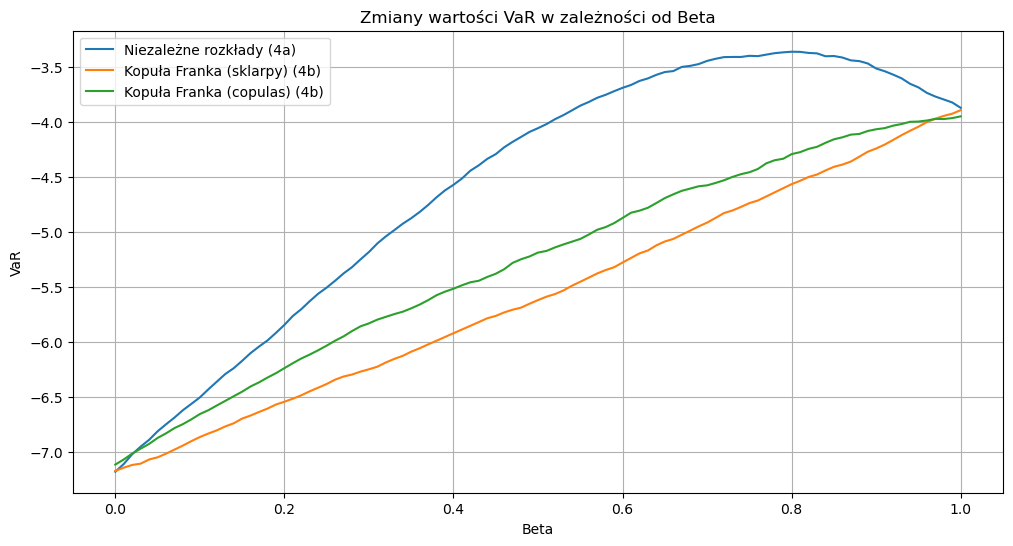

In [69]:
plt.figure(figsize=(12, 6))

plt.plot(var_results["Beta"], var_results["VaR"], label="Niezale≈ºne rozk≈Çady (4a)")
plt.plot(var_results_frank["Beta"], var_results_frank["VaR"], label="Kopu≈Ça Franka (sklarpy) (4b)")
plt.plot(var_results_copula["Beta"], var_results_copula["VaR"], label="Kopu≈Ça Franka (copulas) (4b)")

plt.xlabel("Beta")
plt.ylabel("VaR")
plt.title("Zmiany warto≈õci VaR w zale≈ºno≈õci od Beta")
plt.legend()
plt.grid(True)
plt.show()

Na wykresie widaƒá, jak zmienia siƒô ryzyko portfela przy r√≥≈ºnych proporcjach aktyw√≥w. W przypadku niezale≈ºnych rozk≈Çad√≥w, krzywa VaR jest wygiƒôta, co sugeruje wiƒôkszƒÖ korzy≈õƒá z dywersyfikacji. Natomiast przy zastosowaniu kopu≈Çy, krzywa jest bardziej stroma, co wskazuje na wiƒôksze ryzyko przy pe≈Çnej koncentracji na jednym aktywie.

### Dlaczego¬†Œ≤¬†z kopu≈Çy sƒÖ wy≈ºsze?

Kiedy modelujemy dane za pomocƒÖ kopu≈Çy, uwzglƒôdniamy jak te aktywa wsp√≥≈Çdzia≈ÇajƒÖ ze sobƒÖ. Je≈õli aktywa sƒÖ silnie skorelowane (Apple i Microsoft majƒÖ tendencjƒô do wsp√≥lnego wzrostu lub spadku), to dywersyfikacja (podzia≈Ç portfela miƒôdzy r√≥≈ºne aktywa) staje siƒô mniej efektywna.\
Nie mo≈ºemy "roz≈Ço≈ºyƒá" ryzyka na r√≥≈ºne aktywa w taki spos√≥b, jak by≈õmy to robili w przypadku aktyw√≥w niezale≈ºnych. Optymalne¬†$\beta$¬†z kopu≈Çy bƒôdzie wy≈ºsze, bo koncentracja na jednym aktywie (np. wiƒôksza czƒô≈õƒá portfela w Apple) mo≈ºe minimalizowaƒá ryzyko w takim przypadku, gdzie zale≈ºno≈õci miƒôdzy aktywami zwiƒôkszajƒÖ ryzyko skrajnych strat. Wy≈ºsze¬†$\beta$¬†sugeruje, ≈ºe silne powiƒÖzanie miƒôdzy aktywami sk≈Çania do wiƒôkszej koncentracji na jednym z nich.

## Krok 5
Por√≥wnaƒá wyniki z 4a i 4b. Sprawdziƒá, jak zmieniajƒÖ siƒô wyniki dla dw√≥ch r√≥≈ºnych poziom√≥w VaR i warto≈õci N. Skomentowaƒá.

Por√≥wnamy jak zmieniajƒÖ siƒô wyniki dla VaR 95% i 99% oraz dla pr√≥bek w ilo≈õci 1000, 10000 i 50000:

In [70]:
VaR_levels = [0.05, 0.01]
N_values = [1000, 10000, 50000]

comparison_results = []

for var_level in VaR_levels:
    for N in N_values:
        samples_x1 = marginal_aapl.sample(N)
        samples_x2 = marginal_msft.sample(N)
        portfolio_values = beta_range[:, None] * samples_x1 + (1 - beta_range[:, None]) * samples_x2.T
        # kopu≈Ça z Copulas
        samples_copula = copula.sample(n_samples=N)
        samples_x1_copula = marginal_aapl.ppf(samples_copula[:, 0])
        samples_x2_copula = marginal_msft.ppf(samples_copula[:, 1])
        portfolio_values_copula = beta_range[:, None] * samples_x1_copula + (1 - beta_range[:, None]) * samples_x2_copula.T
        
        var_independent = np.quantile(portfolio_values, var_level, axis=1)
        var_copula = np.quantile(portfolio_values_copula, var_level, axis=1)
        
        comparison_results.append({
            "Poziom VaR": (1-var_level)*100,
            "N": N,
            "Optymalne beta": beta_range[np.argmax(var_independent)],
            "Minimalne VaR": var_independent[np.argmax(var_independent)],
            "Optymalne beta z kopu≈Çy": beta_range[np.argmax(var_copula)],
            "Minimalne VaR z kopu≈Çy": var_copula[np.argmax(var_copula)]
        })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

   Poziom VaR      N  Optymalne beta  Minimalne VaR  Optymalne beta z kopu≈Çy  \
0        95.0   1000            0.78      -3.414332                     0.94   
1        95.0  10000            0.77      -3.522038                     1.00   
2        95.0  50000            0.76      -3.444182                     1.00   
3        99.0   1000            0.78      -5.029886                     0.88   
4        99.0  10000            0.69      -5.571843                     0.93   
5        99.0  50000            0.73      -5.517594                     0.90   

   Minimalne VaR z kopu≈Çy  
0               -4.300138  
1               -3.878828  
2               -3.981131  
3               -5.690666  
4               -6.550675  
5               -6.583962  


## Wnioski

**Wp≈Çyw poziomu VaR:**\
Optymalne¬†ùõΩ¬†sƒÖ wy≈ºsze na poziome VaR (99%), co sugeruje wiƒôkszƒÖ koncentracjƒô inwestycji w jedno aktywo.

**Wp≈Çyw liczby pr√≥bek (N):**\
Wzrost liczby pr√≥bek (N) prowadzi do stabilizacji wynik√≥w. Optymalne $\beta$ i minimalne VaR sƒÖ bardziej zbli≈ºone dla wiƒôkszych warto≈õci N.\
Dla poziomu VaR 95%, optymalne $\beta$ sƒÖ nieco ni≈ºsze przy wiƒôkszych warto≈õciach N, co sugeruje bardziej zr√≥wnowa≈ºony portfel.\
Dla poziomu VaR 99%, optymalne $\beta$ sƒÖ bardziej zmienne, ale og√≥lnie wy≈ºsze ni≈º dla poziomu VaR 95%.

### Co jest bli≈ºsze rzeczywisto≈õci?

Metoda zale≈ºy od danych: Nie mo≈ºemy dowolnie wybieraƒá, czy chcemy mieƒá aktywa niezale≈ºne, czy zale≈ºne ‚Äì to zale≈ºy od tego, jak faktycznie zachowujƒÖ siƒô aktywa w rzeczywisto≈õci. Je≈ºeli aktywa sƒÖ silnie skorelowane (np. Apple i Microsoft czƒôsto poruszajƒÖ siƒô w podobny spos√≥b), to musimy uwzglƒôdniƒá zale≈ºno≈õci miƒôdzy nimi za pomocƒÖ kopu≈Çy.
- Za≈Ço≈ºenie niezale≈ºno≈õci (krok 4a)¬†mo≈ºe prowadziƒá do¬†niedoszacowania ryzyka, poniewa≈º zak≈Çada, ≈ºe aktywa nie wp≈ÇywajƒÖ na siebie, a w rzeczywisto≈õci mogƒÖ. Dlatego mo≈ºe siƒô zdarzyƒá, ≈ºe wyniki bƒôdƒÖ bardziej optymistyczne, bo zak≈Çada siƒô, ≈ºe ryzyko mo≈ºna "roz≈Ço≈ºyƒá".
- Kopu≈Ça (krok 4b)¬†jest bardziej¬†konserwatywna, poniewa≈º lepiej uwzglƒôdnia zale≈ºno≈õci miƒôdzy aktywami. Wskazuje to na wiƒôksze ryzyko, szczeg√≥lnie w ekstremalnych przypadkach (np. kryzysach), gdy aktywa powiƒÖzane silnie tracƒÖ r√≥wnocze≈õnie.